In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)
from sklearn.preprocessing import StandardScaler
# from ts_rnn import Model, Optimization, generate_sequence, to_dataframe, inverse_transform, transform_data
%matplotlib inline

cuda:0


In [2]:
# NOTE: import our RNN modules
# from bayesian_rnn import BRNN
from dropout_rnn import DRNN, Optimization, generate_sequence, to_dataframe, inverse_transform, transform_data # Arka, feel free to change these names

In [51]:
# import datasets
air = pd.read_csv('data/AirQualityUCI.csv', sep=';', skip_blank_lines=True, keep_default_na=True)
finance = pd.read_csv('data/data_akbilgic.csv')
# flu = pd.read_csv('data/NationalILINet.csv')
# flu = pd.read_csv('data/ILINet.csv')
# rnn_data, rnn_label_wILI = load_flu_data(length, first_year,region)

# for air, index 3 is PT08.S1(CO)
# for flu, index 4 is weighted ILI


decay = 1e-6 

def train_dataset(name, df, col_idx, seq_len, dropout_frac = 0.3):
    print('=================================================')
    print('===================',name, '===================')
    df.dropna(how='all', inplace=True)
    train_end_idx, val_end_idx = int(df.shape[0]*0.6), int(df.shape[0]*0.8)
    df_train = df.iloc[:train_end_idx, col_idx].to_frame(name='train')  
    df_val = df.iloc[train_end_idx:val_end_idx, col_idx].to_frame(name='val')  
    df_test = df.iloc[val_end_idx:, col_idx].to_frame(name='test')  

    # data scaling
    scaler = StandardScaler()
    train_arr = scaler.fit_transform(df_train)
    val_arr = scaler.transform(df_val)
    test_arr = scaler.transform(df_test)

    x_train, y_train = transform_data(train_arr, seq_len)
    x_val, y_val = transform_data(val_arr, seq_len)
    x_test, y_test = transform_data(test_arr, seq_len)
    # take a look, it's the same sequence but shifted 1
#     print(x_train[0,:10])
#     print(y_train[0,:10])

    # NOTE: change rnn with ours, e.g. rnn=BRNN
#     lstm = nn.LSTMCell.to(device)
    model_1 = DRNN(input_size=1, hidden_size=21, output_size=1, dropout_frac=dropout_frac, rnn=nn.LSTMCell).to(device)
    loss_fn_1 = nn.MSELoss()
    optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3, weight_decay = decay)
    scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
    optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)
    # train with teacher forcing
    optimization_1.train(x_train.to(device), y_train.to(device), x_val.to(device), y_val.to(device), do_teacher_forcing=True, batch_size=32, n_epochs=15)
    # plot loss
    plt.figure()
    optimization_1.plot_losses()
    
    # evaluation
    print("Evaluation")
    actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=1, batch_size=seq_len)
    df_result_1 = to_dataframe(actual_1, predicted_1) 
    df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
    plt.figure()
    df_result_1.plot(figsize=(14, 7))
#     print("Test loss %.4f" % test_loss_1)
    plt.show()
    
    FUTURE = 15
    test_size = seq_len
    N = x_train.shape[0]
#     print(N)

    # permuting rows to avoid evaluating the same data repeteadly
    perm = torch.randperm(x_test.size(0))
    x_test = x_test[perm]

    predicted_mean, predicted_sd = uncertainty_estimate(x_test[:test_size,:-FUTURE], model_1, num_samples=50, future=FUTURE, dropout_rate=dropout_frac, decay=decay, N=N)
    
    gt = x_test[:test_size,:].cpu().detach().numpy()
    gt = scaler.inverse_transform(gt)
#     print(predicted_mean)
#     print(y_test[:test_size,-FUTURE:])
#     test_mse_loss = nn.functional.mse_loss(predicted_mean,y_test[:test_size,-FUTURE:],reduction='mean').cpu().detach().numpy()
#     print('test mse loss ',test_mse_loss)
#     print('gt',gt.shape)
    
    seq_length = 0
    i = 12
    mean = predicted_mean.cpu().detach().numpy()
    std = predicted_sd.cpu().detach().numpy()
    future = mean.shape[1]
    seq_length = x_test.shape[1]
    x_gt = np.arange(seq_length)
    x_pred = np.arange(seq_length-future,seq_length)
    for count in np.arange(3):
        i = np.asscalar(np.random.randint(low=0, high=test_size, size=1))
        print(i)
        print(std[i,:])
        plt.figure
        plt.plot(x_gt, gt[i,:], color='orange', label='Ground Truth')
        plt.plot(x_pred, mean[i,:], color='b', label='Mean Posterior Predictive')
        plt.fill_between(x_pred, mean[i,:]-2*std[i,:], mean[i,:]+2*std[i,:], color='grey', alpha = 0.25, label='95% Confidence')
        plt.legend()
        plt.xlim((70,100))
#         plt.ylim((0,2000))
        plt.show()
    
    count = 0
    real = gt[:,-FUTURE:]
    print(real.shape)
    print(mean.shape)
    for i in np.arange(mean.shape[0]):
        for j in np.arange(mean.shape[1]):
            if real[i,j]>(mean[i,j]+2*std[i,j]) or real[i,j]<(mean[i,j]-2*std[i,j]):
                count = count + 1
    interval = 1 - count/(real.shape[0]*real.shape[1])
    print('95 % interval',interval)
    rmse = np.sqrt(np.mean(np.square(real-mean)))
    print('rmse',rmse)
#     return predicted_mean, predicted_sd, interval


In [24]:
def uncertainty_estimate(x, model, num_samples, future, dropout_rate, decay, N, l2=0.01):
    x = x.to(device)
#         print(x.shape)
#         print(self.model(x, future=future)[:,-future:].cpu().detach().numpy())
#     print(model(x, future=future)[:,-future:].cpu().detach().numpy().shape)
#         outputs = np.hstack([self.model(x, future=future)[:,-future:].cpu().detach().numpy() for i in range(num_samples)]) # n번 inference, output.shape = [20, N]
    # CONE ESTIMATION
    outputs = torch.zeros((x.shape[0], future, num_samples))
    
    for s in range(num_samples):
        new_gt = torch.Tensor([]).to(device)
        for f in range(future):
            if new_gt.size() != torch.Size([0]):
#                 x_new = torch.cat((x, new_gt.view(-1,1)),1)
                x_new = torch.cat((x_new, new_gt.view(-1,1)),1)
            else:
                x_new = x
#             new_gt = model(x, future=1)[:,-1]
            new_gt = model(x_new, future=1)[:,-1]
            outputs[:,f,s]=new_gt
    print('shape',outputs.shape)
#     print(outputs.mean(-1))
#     print(outputs.std(-1))
    y_variance = outputs.var(axis=-1)
    outputs = torch.Tensor(scaler.inverse_transform(outputs.cpu().detach().numpy()))
    tau = l2 * (1. - dropout_rate) / (2. * N * decay) # What is this doing??
    y_variance += (1. / tau)
    return outputs.mean(-1), outputs.std(-1)

In [13]:
# uncertainity_estimate(x, model, num_samples, l2, future)
# from dropout_rnn import DRNN, Optimization, generate_sequence, to_dataframe, inverse_transform, transform_data # Arka, feel free to change these names
FUTURE = 15
test_size = 100
N = x_train.shape[0]
print(N)

# permuting rows to avoid evaluating the same data repeteadly
perm = torch.randperm(x_test.size(0))
x_test = x_test[perm]

predicted_mean, predicted_sd = uncertainty_estimate(x_test[:test_size,:-FUTURE], model_1, num_samples=50, future=FUTURE, dropout_rate=dropout_frac, decay=decay, N=N)

5514
shape torch.Size([100, 15, 50])


=================== air-CO 0.2 ===================
Epoch 1 Train loss: 0.84. Validation loss: 1.19. Avg future: 25.42. Elapsed time: 4.93s.
Epoch 2 Train loss: 0.53. Validation loss: 0.65. Avg future: 24.67. Elapsed time: 4.91s.
Epoch 3 Train loss: 0.34. Validation loss: 0.38. Avg future: 22.28. Elapsed time: 4.92s.
Epoch 4 Train loss: 0.25. Validation loss: 0.31. Avg future: 25.87. Elapsed time: 7.00s.
Epoch 5 Train loss: 0.22. Validation loss: 0.28. Avg future: 25.27. Elapsed time: 7.94s.
Epoch 6 Train loss: 0.21. Validation loss: 0.28. Avg future: 25.76. Elapsed time: 7.82s.
Epoch 7 Train loss: 0.21. Validation loss: 0.28. Avg future: 25.55. Elapsed time: 7.80s.
Epoch 8 Train loss: 0.21. Validation loss: 0.28. Avg future: 25.62. Elapsed time: 8.16s.
Epoch 9 Train loss: 0.21. Validation loss: 0.28. Avg future: 24.22. Elapsed time: 8.07s.
Epoch 10 Train loss: 0.21. Validation loss: 0.28. Avg future: 24.50. Elapsed time: 7.87s.
Evaluation
Test loss 0.0706


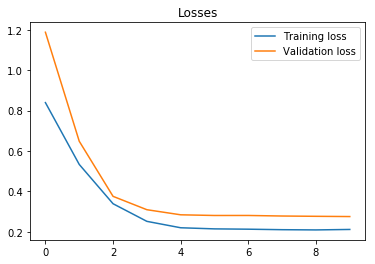

<Figure size 432x288 with 0 Axes>

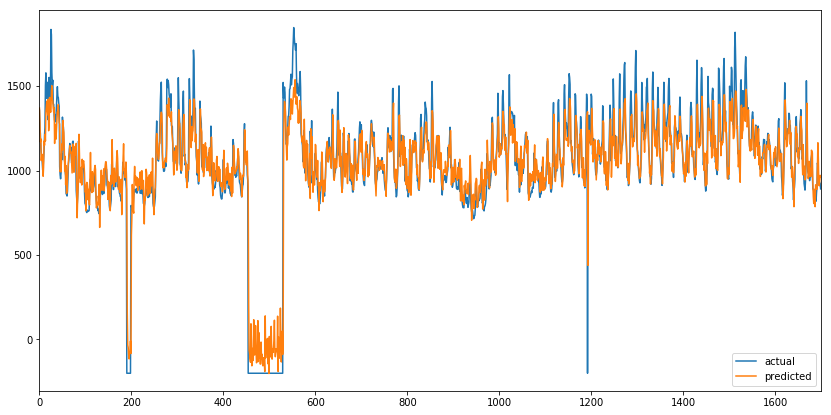

shape torch.Size([100, 15, 50])
6
[45.454002 59.486958 69.50492  62.044605 52.55382  40.029472 36.983696
 47.575657 52.42276  47.591896 48.020687 45.71734  50.14143  55.179283
 56.02325 ]


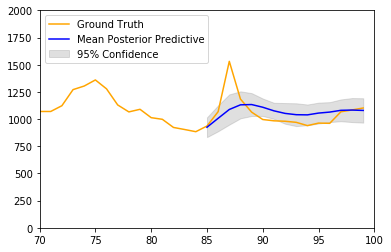

51
[30.560604 35.013927 41.38302  45.543385 54.700542 47.54997  46.32156
 48.202835 58.4348   56.0812   47.97579  39.658463 45.08167  44.54465
 45.047436]


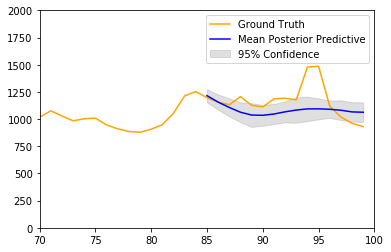

41
[ 77.07944   83.227165 102.87288  114.99725  150.96501  173.74622
 218.55031  269.61884  317.59677  347.4155   339.47186  306.4581
 257.73544  207.90489  143.8235  ]


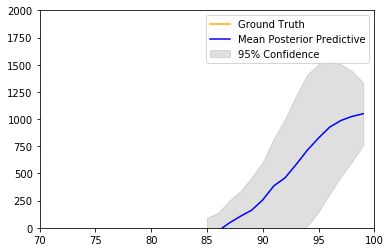

(100, 15)
(100, 15)
95 % interval 0.42400000000000004
rmse 294.90918
=================== air-CO 0.3 ===================
Epoch 1 Train loss: 0.77. Validation loss: 1.03. Avg future: 27.44. Elapsed time: 7.82s.
Epoch 2 Train loss: 0.46. Validation loss: 0.49. Avg future: 24.87. Elapsed time: 7.75s.
Epoch 3 Train loss: 0.31. Validation loss: 0.36. Avg future: 27.10. Elapsed time: 7.76s.
Epoch 4 Train loss: 0.25. Validation loss: 0.33. Avg future: 25.85. Elapsed time: 7.76s.
Epoch 5 Train loss: 0.24. Validation loss: 0.30. Avg future: 24.33. Elapsed time: 8.00s.
Epoch 6 Train loss: 0.23. Validation loss: 0.30. Avg future: 26.99. Elapsed time: 7.74s.
Epoch 7 Train loss: 0.22. Validation loss: 0.30. Avg future: 26.31. Elapsed time: 7.80s.
Epoch 8 Train loss: 0.22. Validation loss: 0.30. Avg future: 26.53. Elapsed time: 7.80s.
Epoch 9 Train loss: 0.21. Validation loss: 0.30. Avg future: 26.78. Elapsed time: 7.83s.
Epoch 10 Train loss: 0.22. Validation loss: 0.30. Avg future: 25.74. Elapsed ti

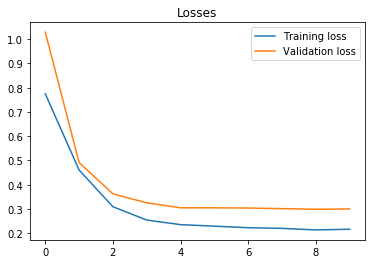

<Figure size 432x288 with 0 Axes>

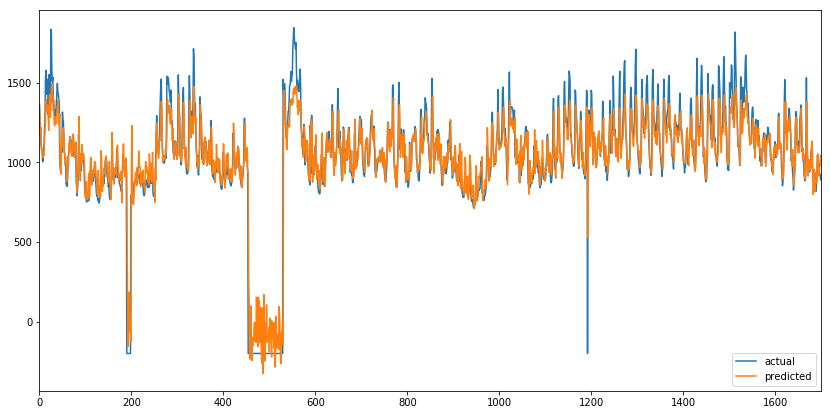

shape torch.Size([100, 15, 50])
88
[23.175852 36.88143  50.368843 45.34839  39.51481  30.489487 28.728668
 35.462345 43.405525 38.569473 37.223324 38.975136 34.940422 34.14806
 36.65072 ]


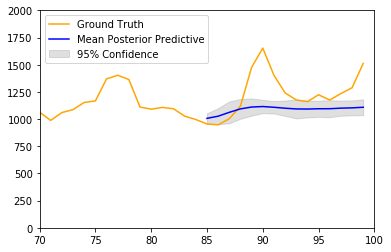

21
[27.082867 37.420162 45.899918 45.66267  45.95966  41.590492 43.559933
 44.706013 46.146812 45.479538 35.67391  38.10576  40.68926  43.93295
 40.326813]


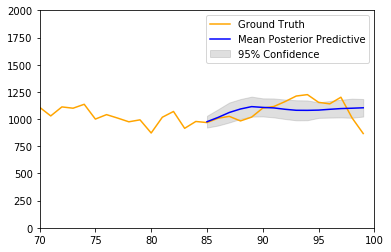

19
[30.282648 44.069817 41.713474 48.52401  51.777855 49.368076 41.89719
 43.441807 37.24804  30.265266 28.007706 33.86327  31.997757 36.875084
 34.087345]


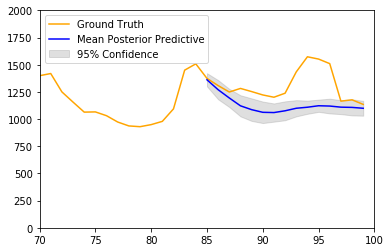

(100, 15)
(100, 15)
95 % interval 0.364
rmse 279.61002
=================== air-CO 0.4 ===================
Epoch 1 Train loss: 0.83. Validation loss: 1.19. Avg future: 24.90. Elapsed time: 7.77s.
Epoch 2 Train loss: 0.53. Validation loss: 0.62. Avg future: 27.56. Elapsed time: 7.76s.
Epoch 3 Train loss: 0.35. Validation loss: 0.42. Avg future: 24.40. Elapsed time: 7.82s.
Epoch 4 Train loss: 0.28. Validation loss: 0.36. Avg future: 27.10. Elapsed time: 7.85s.
Epoch 5 Train loss: 0.25. Validation loss: 0.33. Avg future: 24.55. Elapsed time: 7.84s.
Epoch 6 Train loss: 0.24. Validation loss: 0.33. Avg future: 25.60. Elapsed time: 7.82s.
Epoch 7 Train loss: 0.23. Validation loss: 0.33. Avg future: 24.53. Elapsed time: 7.89s.
Epoch 8 Train loss: 0.24. Validation loss: 0.33. Avg future: 25.22. Elapsed time: 7.75s.
Epoch 9 Train loss: 0.23. Validation loss: 0.33. Avg future: 24.87. Elapsed time: 7.67s.
Epoch 10 Train loss: 0.23. Validation loss: 0.32. Avg future: 25.88. Elapsed time: 7.68s.
Eva

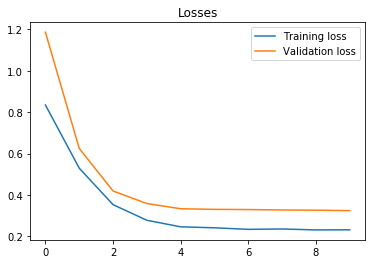

<Figure size 432x288 with 0 Axes>

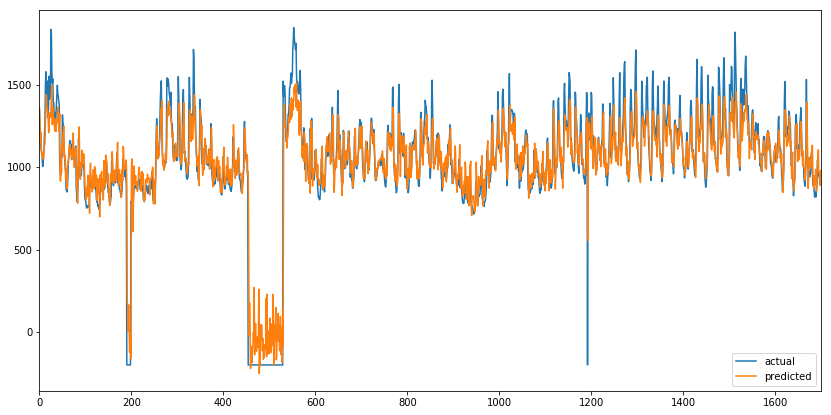

shape torch.Size([100, 15, 50])
82
[22.045033 34.859074 37.392887 39.235638 46.545807 45.097256 42.239967
 36.59027  39.674984 44.402626 42.88141  39.039764 38.202496 39.180645
 42.699863]


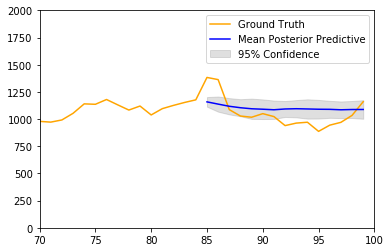

68
[39.099144 56.618687 59.721577 54.978893 47.535225 44.653477 42.190365
 40.12235  36.66829  34.66466  36.53161  38.07058  40.687634 32.12852
 34.785774]


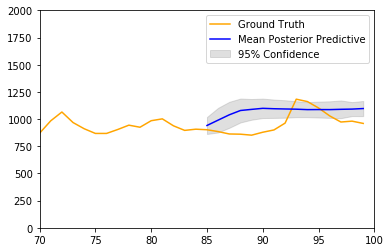

80
[38.643047 59.844433 67.1007   66.19433  62.02781  51.081375 46.662827
 42.609398 39.945747 34.745846 36.960606 37.477245 38.28433  32.89501
 28.86914 ]


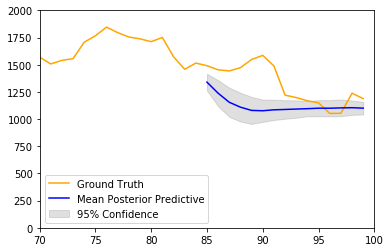

(100, 15)
(100, 15)
95 % interval 0.3973333333333333
rmse 301.2347
=================== air-CO 0.5 ===================
Epoch 1 Train loss: 0.78. Validation loss: 1.10. Avg future: 26.14. Elapsed time: 7.79s.
Epoch 2 Train loss: 0.47. Validation loss: 0.54. Avg future: 24.81. Elapsed time: 7.85s.
Epoch 3 Train loss: 0.32. Validation loss: 0.43. Avg future: 25.05. Elapsed time: 7.94s.
Epoch 4 Train loss: 0.28. Validation loss: 0.39. Avg future: 24.80. Elapsed time: 7.81s.
Epoch 5 Train loss: 0.26. Validation loss: 0.37. Avg future: 25.13. Elapsed time: 7.79s.
Epoch 6 Train loss: 0.26. Validation loss: 0.37. Avg future: 23.84. Elapsed time: 7.82s.
Epoch 7 Train loss: 0.25. Validation loss: 0.37. Avg future: 25.66. Elapsed time: 7.73s.
Epoch 8 Train loss: 0.25. Validation loss: 0.36. Avg future: 22.94. Elapsed time: 7.99s.
Epoch 9 Train loss: 0.24. Validation loss: 0.37. Avg future: 23.80. Elapsed time: 7.95s.
Epoch 10 Train loss: 0.24. Validation loss: 0.36. Avg future: 24.87. Elapsed time

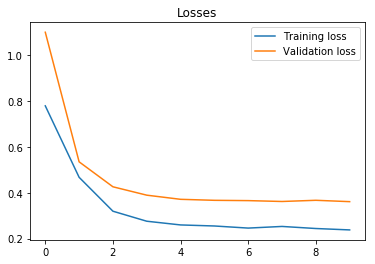

<Figure size 432x288 with 0 Axes>

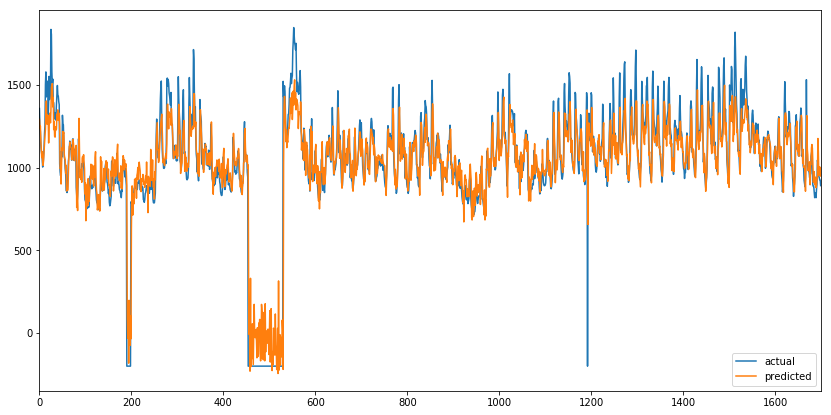

shape torch.Size([100, 15, 50])
68
[26.45301  25.136154 30.682781 33.70567  30.490774 29.036198 25.05001
 24.234629 24.998201 24.252249 23.695019 20.887596 24.81468  23.871824
 25.236418]


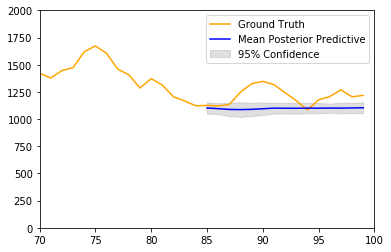

96
[16.851377 22.41419  24.69602  24.426466 28.005518 30.06039  28.567211
 24.707918 24.205484 29.534693 26.617628 21.68922  23.74508  26.763046
 26.380287]


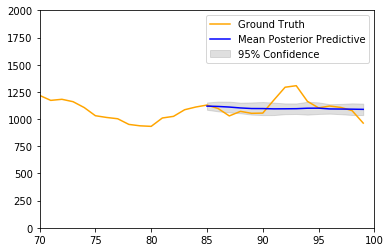

4
[28.53537  37.10689  39.6719   36.958305 33.70539  35.861767 31.291298
 28.094975 29.598469 24.490452 26.251472 24.977858 25.09657  28.960987
 29.233229]


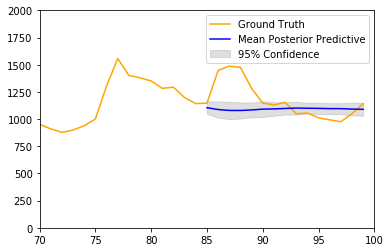

(100, 15)
(100, 15)
95 % interval 0.28400000000000003
rmse 221.9


In [30]:
train_dataset('air-CO 0.2', air, 3, 100, dropout_frac=0.2)
train_dataset('air-CO 0.3', air, 3, 100, dropout_frac=0.3)
train_dataset('air-CO 0.4', air, 3, 100, dropout_frac=0.4)
train_dataset('air-CO 0.5', air, 3, 100, dropout_frac=0.5)

=================== air-NOx 0.2 ===================
Epoch 1 Train loss: 0.73. Validation loss: 0.99. Avg future: 24.95. Elapsed time: 7.68s.
Epoch 2 Train loss: 0.42. Validation loss: 0.54. Avg future: 24.06. Elapsed time: 7.90s.
Epoch 3 Train loss: 0.30. Validation loss: 0.40. Avg future: 27.23. Elapsed time: 7.92s.
Epoch 4 Train loss: 0.24. Validation loss: 0.32. Avg future: 23.92. Elapsed time: 7.77s.
Epoch 5 Train loss: 0.21. Validation loss: 0.29. Avg future: 25.31. Elapsed time: 7.77s.
Epoch 6 Train loss: 0.20. Validation loss: 0.28. Avg future: 23.92. Elapsed time: 7.95s.
Epoch 7 Train loss: 0.20. Validation loss: 0.28. Avg future: 24.45. Elapsed time: 7.82s.
Epoch 8 Train loss: 0.19. Validation loss: 0.28. Avg future: 26.95. Elapsed time: 7.73s.
Epoch 9 Train loss: 0.19. Validation loss: 0.28. Avg future: 24.13. Elapsed time: 7.72s.
Epoch 10 Train loss: 0.19. Validation loss: 0.27. Avg future: 23.58. Elapsed time: 7.76s.
Evaluation
shape torch.Size([100, 15, 50])
68
[30.54954  

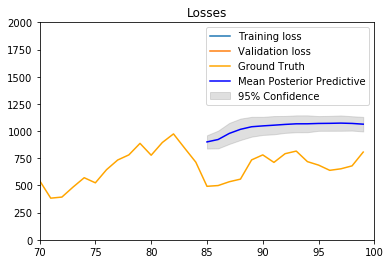

95
[21.791965 35.062393 42.556087 47.369507 48.568874 39.27669  36.192204
 30.761541 33.339962 41.55644  42.437214 37.451435 34.842537 33.441093
 34.17577 ]


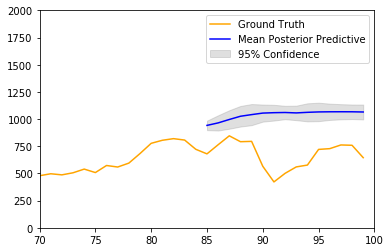

11
[23.191355 31.135172 42.28122  40.675415 39.220463 39.757122 40.20066
 40.604904 40.946007 43.75565  41.904903 36.422943 35.964752 34.17005
 34.312557]


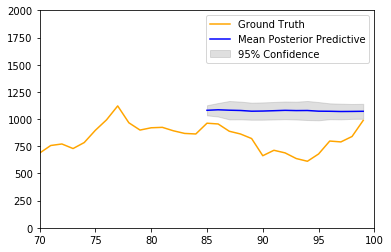

(100, 15)
(100, 15)
95 % interval 0.13666666666666671
rmse 369.44028
=================== air-NOx 0.3 ===================
Epoch 1 Train loss: 0.78. Validation loss: 1.02. Avg future: 27.17. Elapsed time: 7.72s.
Epoch 2 Train loss: 0.43. Validation loss: 0.52. Avg future: 26.20. Elapsed time: 7.79s.
Epoch 3 Train loss: 0.29. Validation loss: 0.38. Avg future: 25.05. Elapsed time: 7.85s.
Epoch 4 Train loss: 0.23. Validation loss: 0.32. Avg future: 25.85. Elapsed time: 7.81s.
Epoch 5 Train loss: 0.21. Validation loss: 0.30. Avg future: 25.87. Elapsed time: 7.86s.
Epoch 6 Train loss: 0.20. Validation loss: 0.30. Avg future: 27.36. Elapsed time: 7.85s.
Epoch 7 Train loss: 0.20. Validation loss: 0.30. Avg future: 25.58. Elapsed time: 7.94s.
Epoch 8 Train loss: 0.20. Validation loss: 0.30. Avg future: 25.72. Elapsed time: 7.90s.
Epoch 9 Train loss: 0.20. Validation loss: 0.30. Avg future: 25.51. Elapsed time: 7.94s.
Epoch 10 Train loss: 0.20. Validation loss: 0.29. Avg future: 25.58. Elapsed t

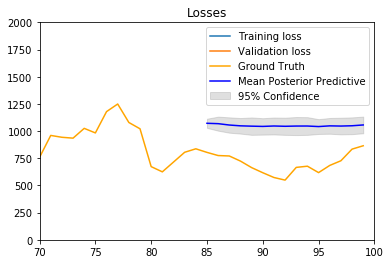

10
[36.39588  60.05547  70.740486 75.019875 86.782974 87.96989  76.6092
 67.71208  60.071377 55.60032  50.582767 43.553356 40.95547  49.861618
 44.64127 ]


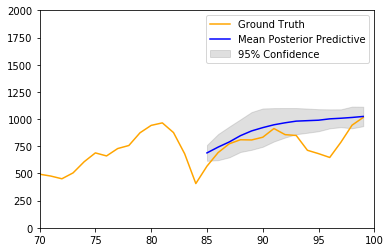

13
[34.518196 48.508995 45.693962 42.19384  43.019783 40.711227 43.47845
 45.01668  42.82945  38.54692  35.148964 38.91879  39.4747   45.584743
 43.10191 ]


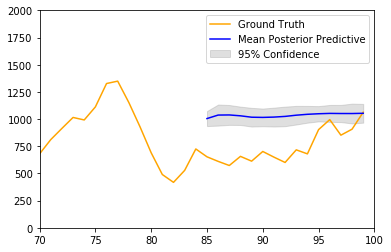

(100, 15)
(100, 15)
95 % interval 0.1146666666666667
rmse 395.55872
=================== air-NOx 0.4 ===================
Epoch 1 Train loss: 0.82. Validation loss: 1.22. Avg future: 23.42. Elapsed time: 7.72s.
Epoch 2 Train loss: 0.50. Validation loss: 0.62. Avg future: 26.57. Elapsed time: 7.82s.
Epoch 3 Train loss: 0.34. Validation loss: 0.44. Avg future: 26.06. Elapsed time: 7.90s.
Epoch 4 Train loss: 0.26. Validation loss: 0.38. Avg future: 24.31. Elapsed time: 7.83s.
Epoch 5 Train loss: 0.23. Validation loss: 0.34. Avg future: 25.10. Elapsed time: 8.04s.
Epoch 6 Train loss: 0.22. Validation loss: 0.34. Avg future: 23.44. Elapsed time: 7.81s.
Epoch 7 Train loss: 0.22. Validation loss: 0.34. Avg future: 26.41. Elapsed time: 8.03s.
Epoch 8 Train loss: 0.21. Validation loss: 0.33. Avg future: 26.01. Elapsed time: 7.97s.
Epoch 9 Train loss: 0.21. Validation loss: 0.33. Avg future: 26.73. Elapsed time: 8.59s.
Epoch 10 Train loss: 0.22. Validation loss: 0.33. Avg future: 23.49. Elapsed ti

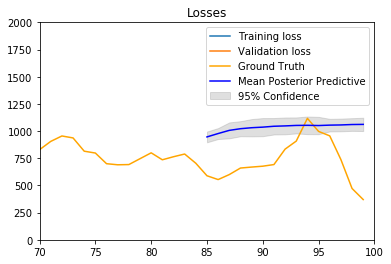

62
[ 84.50828  104.19724   91.67291   79.536415  71.23411   56.946426
  46.227314  43.681644  39.740383  38.226078  42.20131   42.116726
  34.445625  35.847904  32.85814 ]


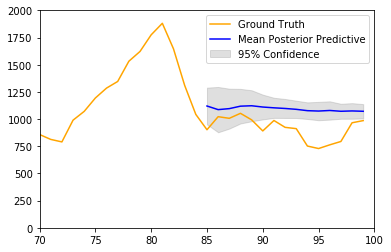

56
[40.42382  61.786884 72.22621  83.74247  73.913956 61.95966  57.435062
 56.09949  42.97671  35.194214 30.888247 28.034384 25.428795 27.795725
 28.927935]


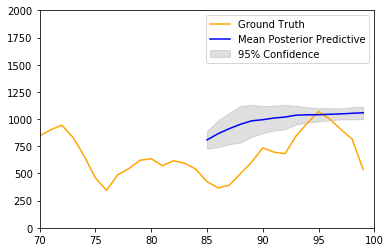

(100, 15)
(100, 15)
95 % interval 0.14800000000000002
rmse 354.40192
=================== air-NOx 0.5 ===================
Epoch 1 Train loss: 0.66. Validation loss: 0.87. Avg future: 25.97. Elapsed time: 8.02s.
Epoch 2 Train loss: 0.40. Validation loss: 0.57. Avg future: 26.15. Elapsed time: 8.19s.
Epoch 3 Train loss: 0.31. Validation loss: 0.46. Avg future: 25.64. Elapsed time: 8.27s.
Epoch 4 Train loss: 0.26. Validation loss: 0.41. Avg future: 25.92. Elapsed time: 8.25s.
Epoch 5 Train loss: 0.24. Validation loss: 0.38. Avg future: 27.19. Elapsed time: 8.17s.
Epoch 6 Train loss: 0.24. Validation loss: 0.38. Avg future: 24.98. Elapsed time: 7.84s.
Epoch 7 Train loss: 0.23. Validation loss: 0.37. Avg future: 25.49. Elapsed time: 7.97s.
Epoch 8 Train loss: 0.23. Validation loss: 0.37. Avg future: 23.62. Elapsed time: 8.03s.
Epoch 9 Train loss: 0.23. Validation loss: 0.37. Avg future: 26.31. Elapsed time: 7.75s.
Epoch 10 Train loss: 0.23. Validation loss: 0.37. Avg future: 25.20. Elapsed t

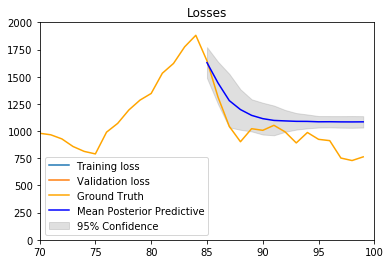

84
[49.50778  78.05432  74.82888  71.68061  57.02016  45.365856 44.2272
 38.81314  35.303013 28.74254  24.891727 24.330023 24.265003 25.96251
 27.536345]


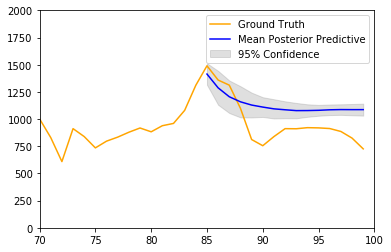

79
[70.86242  87.44811  91.62334  88.8422   76.794365 68.90288  61.817677
 56.86385  61.50787  62.093086 56.46478  48.01911  46.80772  42.07117
 32.21726 ]


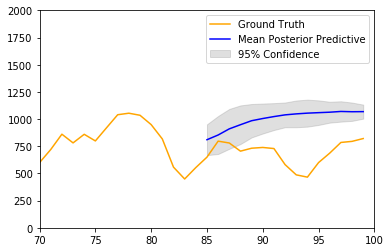

(100, 15)
(100, 15)
95 % interval 0.08999999999999997
rmse 394.7487


In [33]:
train_dataset('air-NOx 0.2', air, 8, 100, dropout_frac=0.2)
train_dataset('air-NOx 0.3', air, 8, 100, dropout_frac=0.3)
train_dataset('air-NOx 0.4', air, 8, 100, dropout_frac=0.4)
train_dataset('air-NOx 0.5', air, 8, 100, dropout_frac=0.5)


=================== air-NO2 0.2 ===================
Epoch 1 Train loss: 0.83. Validation loss: 0.98. Avg future: 24.75. Elapsed time: 8.43s.
Epoch 2 Train loss: 0.48. Validation loss: 0.46. Avg future: 25.30. Elapsed time: 7.87s.
Epoch 3 Train loss: 0.33. Validation loss: 0.30. Avg future: 25.83. Elapsed time: 8.33s.
Epoch 4 Train loss: 0.26. Validation loss: 0.26. Avg future: 27.00. Elapsed time: 8.47s.
Epoch 5 Train loss: 0.23. Validation loss: 0.25. Avg future: 24.62. Elapsed time: 7.87s.
Epoch 6 Train loss: 0.22. Validation loss: 0.24. Avg future: 26.81. Elapsed time: 8.42s.
Epoch 7 Train loss: 0.22. Validation loss: 0.24. Avg future: 25.85. Elapsed time: 8.29s.
Epoch 8 Train loss: 0.22. Validation loss: 0.24. Avg future: 24.31. Elapsed time: 8.21s.
Epoch 9 Train loss: 0.21. Validation loss: 0.24. Avg future: 26.87. Elapsed time: 8.58s.
Epoch 10 Train loss: 0.22. Validation loss: 0.24. Avg future: 26.47. Elapsed time: 8.42s.
Epoch 11 Train loss: 0.22. Validation loss: 0.24. Avg fut

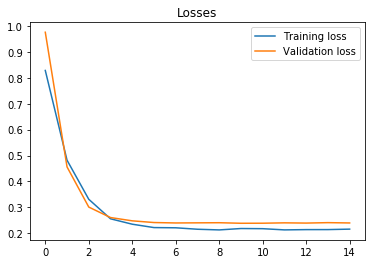

<Figure size 432x288 with 0 Axes>

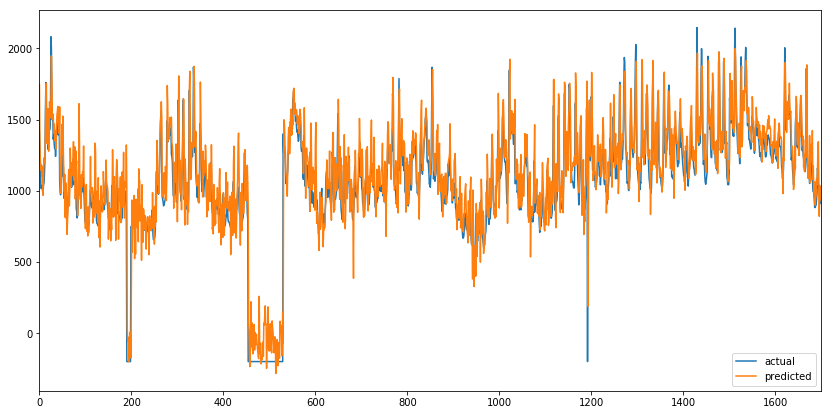

shape torch.Size([100, 15, 50])
83
[ 92.574165 129.42966  148.64249  129.81358  117.771065 108.43778
  91.86117   74.1673    63.014587  56.92007   56.85487   47.262768
  45.22685   40.156918  35.87887 ]


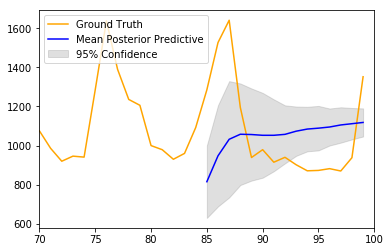

47
[ 69.37198 106.95216 158.56578 189.6272  198.31757 176.64795 168.00563
 172.6026  158.31508 159.32744 154.63107 135.04471 117.01178 107.65408
  99.98168]


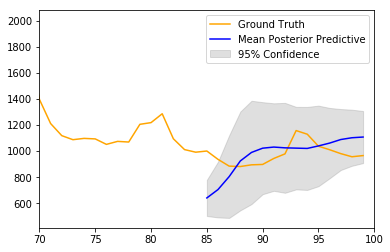

92
[ 76.03685  105.926094 116.752426 115.01325  147.06808  140.84837
 150.97142  172.57066  210.77968  229.6073   275.34033  306.08466
 328.87128  351.07205  362.82623 ]


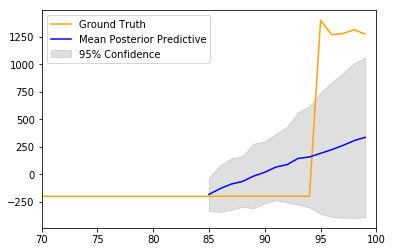

(100, 15)
(100, 15)
95 % interval 0.526
rmse 307.72046
=================== air-NO2 0.3 ===================
Epoch 1 Train loss: 0.78. Validation loss: 1.06. Avg future: 26.80. Elapsed time: 8.15s.
Epoch 2 Train loss: 0.50. Validation loss: 0.51. Avg future: 25.00. Elapsed time: 7.82s.
Epoch 3 Train loss: 0.34. Validation loss: 0.35. Avg future: 26.54. Elapsed time: 8.00s.
Epoch 4 Train loss: 0.27. Validation loss: 0.30. Avg future: 24.82. Elapsed time: 8.14s.
Epoch 5 Train loss: 0.25. Validation loss: 0.28. Avg future: 24.73. Elapsed time: 8.22s.
Epoch 6 Train loss: 0.23. Validation loss: 0.28. Avg future: 27.11. Elapsed time: 7.71s.
Epoch 7 Train loss: 0.23. Validation loss: 0.28. Avg future: 23.48. Elapsed time: 8.41s.
Epoch 8 Train loss: 0.23. Validation loss: 0.28. Avg future: 24.70. Elapsed time: 8.38s.
Epoch 9 Train loss: 0.23. Validation loss: 0.27. Avg future: 25.43. Elapsed time: 8.22s.
Epoch 10 Train loss: 0.23. Validation loss: 0.27. Avg future: 25.37. Elapsed time: 8.31s.
Ep

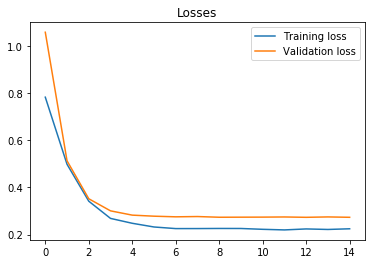

<Figure size 432x288 with 0 Axes>

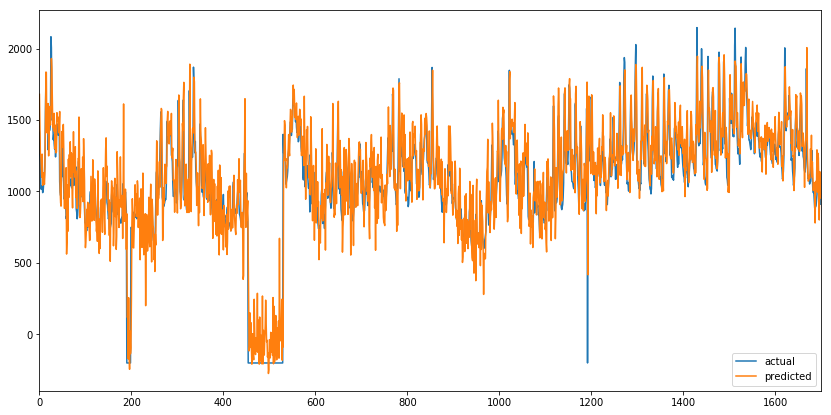

shape torch.Size([100, 15, 50])
12
[101.12459 154.47015 185.50533 187.47702 180.02283 162.57237 146.04897
 135.33902 129.53831 111.09157 130.55168 132.96696 138.66148 128.2014
 111.37153]


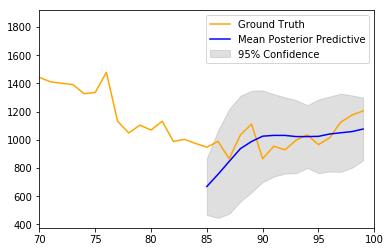

62
[ 80.800545 150.19095  174.85379  171.69641  158.50763  139.47116
 133.16435  122.68148  139.38051  133.04675  141.22124  144.27243
 151.7501   118.525826 121.093704]


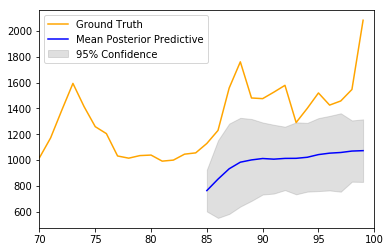

75
[ 89.17916  93.05318 126.07966 130.05537 161.41075 200.17992 226.25893
 245.46884 265.74213 295.98868 292.0857  325.3882  339.30423 375.32
 388.45312]


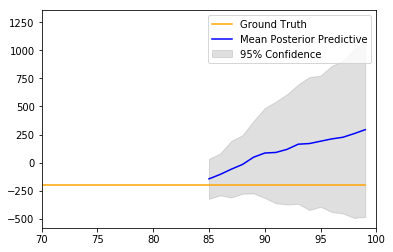

(100, 15)
(100, 15)
95 % interval 0.6053333333333333
rmse 306.4588
=================== air-NO2 0.4 ===================
Epoch 1 Train loss: 0.83. Validation loss: 1.31. Avg future: 25.34. Elapsed time: 7.73s.
Epoch 2 Train loss: 0.55. Validation loss: 0.65. Avg future: 24.21. Elapsed time: 7.90s.
Epoch 3 Train loss: 0.36. Validation loss: 0.39. Avg future: 26.98. Elapsed time: 8.09s.
Epoch 4 Train loss: 0.28. Validation loss: 0.34. Avg future: 26.09. Elapsed time: 8.15s.
Epoch 5 Train loss: 0.25. Validation loss: 0.31. Avg future: 27.31. Elapsed time: 8.22s.
Epoch 6 Train loss: 0.24. Validation loss: 0.31. Avg future: 25.49. Elapsed time: 8.14s.
Epoch 7 Train loss: 0.24. Validation loss: 0.31. Avg future: 23.70. Elapsed time: 7.96s.
Epoch 8 Train loss: 0.24. Validation loss: 0.31. Avg future: 25.33. Elapsed time: 8.38s.
Epoch 9 Train loss: 0.24. Validation loss: 0.31. Avg future: 25.16. Elapsed time: 8.25s.
Epoch 10 Train loss: 0.24. Validation loss: 0.31. Avg future: 24.19. Elapsed tim

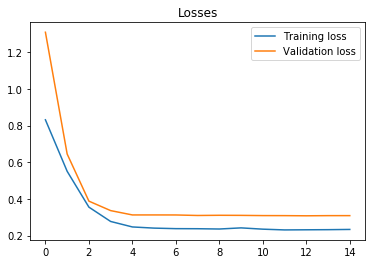

<Figure size 432x288 with 0 Axes>

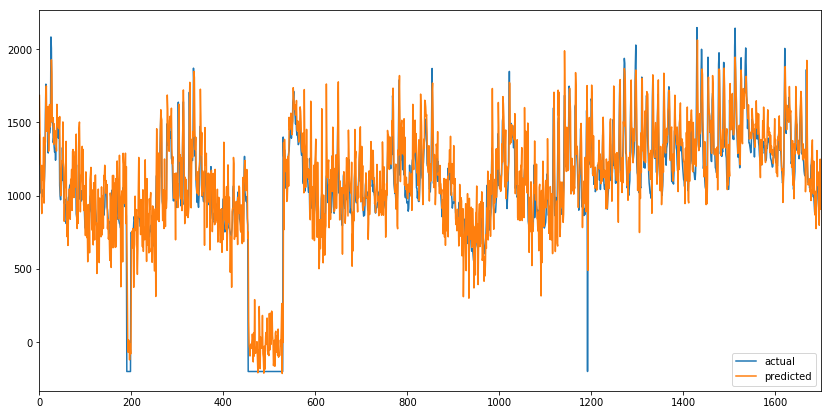

shape torch.Size([100, 15, 50])
79
[129.11264 240.29327 297.13654 316.03482 327.7859  315.20544 306.90485
 308.0835  297.52423 265.54648 246.20662 251.54414 233.41907 219.08226
 215.20718]


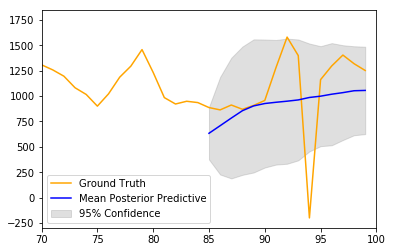

48
[151.54439 248.29866 304.80505 346.23843 393.05164 415.1214  423.59744
 423.77213 443.11667 419.06882 405.5375  412.23132 413.96835 413.57016
 389.11646]


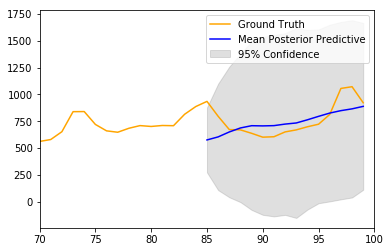

64
[31.478601 41.1678   42.094624 38.205185 31.787209 34.07818  32.72737
 34.05051  32.940098 35.33347  36.541477 38.065468 35.038    38.173683
 38.487263]


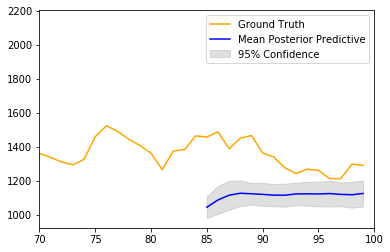

(100, 15)
(100, 15)
95 % interval 0.6713333333333333
rmse 282.45398
=================== air-NO2 0.5 ===================
Epoch 1 Train loss: 0.80. Validation loss: 1.10. Avg future: 25.73. Elapsed time: 7.82s.
Epoch 2 Train loss: 0.48. Validation loss: 0.52. Avg future: 27.22. Elapsed time: 7.77s.
Epoch 3 Train loss: 0.34. Validation loss: 0.41. Avg future: 26.98. Elapsed time: 7.86s.
Epoch 4 Train loss: 0.28. Validation loss: 0.38. Avg future: 24.38. Elapsed time: 7.76s.
Epoch 5 Train loss: 0.26. Validation loss: 0.36. Avg future: 24.49. Elapsed time: 7.85s.
Epoch 6 Train loss: 0.26. Validation loss: 0.35. Avg future: 25.97. Elapsed time: 7.92s.
Epoch 7 Train loss: 0.25. Validation loss: 0.35. Avg future: 25.72. Elapsed time: 8.00s.
Epoch 8 Train loss: 0.25. Validation loss: 0.35. Avg future: 23.52. Elapsed time: 7.88s.
Epoch 9 Train loss: 0.25. Validation loss: 0.35. Avg future: 25.45. Elapsed time: 7.85s.
Epoch 10 Train loss: 0.25. Validation loss: 0.35. Avg future: 23.97. Elapsed ti

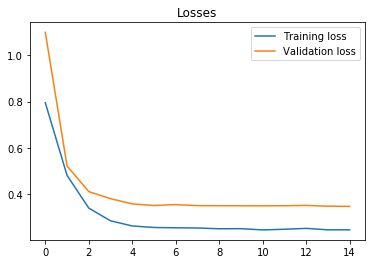

<Figure size 432x288 with 0 Axes>

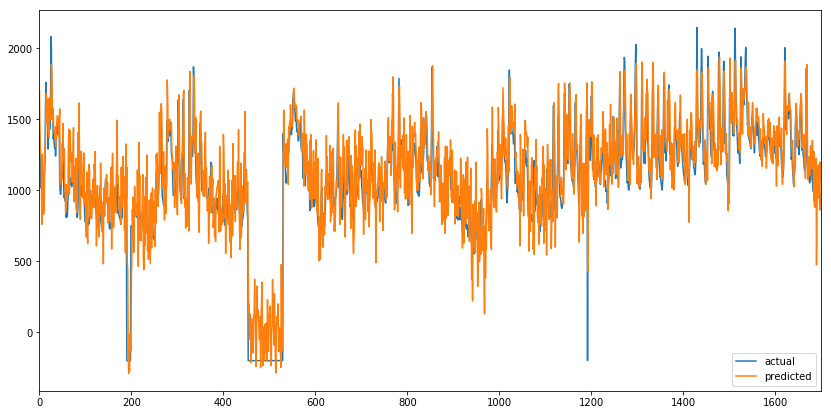

shape torch.Size([100, 15, 50])
46
[121.05872 195.30904 237.71599 268.29373 252.74432 241.35121 234.82986
 225.09528 254.33022 223.20392 236.12555 257.76703 221.5704  209.16429
 167.03456]


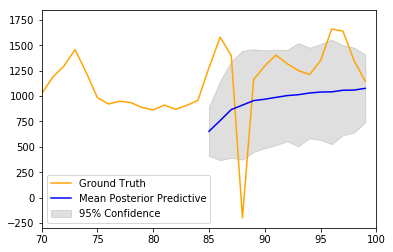

87
[104.5431  189.61505 297.38306 342.9566  362.9517  369.00497 353.4022
 316.36493 271.03372 249.92545 281.07843 284.14496 259.91403 234.80199
 232.187  ]


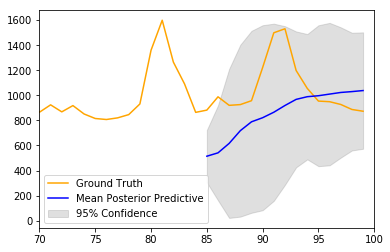

81
[ 93.675545 172.51207  201.74292  242.21083  230.93513  241.59041
 246.57996  212.75162  181.86598  151.8957   112.309135  99.61775
  69.73592   59.390118  66.298386]


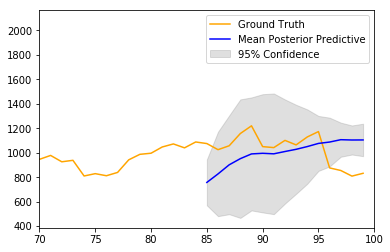

(100, 15)
(100, 15)
95 % interval 0.5966666666666667
rmse 302.90704


In [52]:
train_dataset('air-NO2 0.2', air, 10, 100, dropout_frac=0.2)
train_dataset('air-NO2 0.3', air, 10, 100, dropout_frac=0.3)
train_dataset('air-NO2 0.4', air, 10, 100, dropout_frac=0.4)
train_dataset('air-NO2 0.5', air, 10, 100, dropout_frac=0.5)


=================== air-O3 0.2 ===================
Epoch 1 Train loss: 0.77. Validation loss: 0.88. Avg future: 25.59. Elapsed time: 4.95s.
Epoch 2 Train loss: 0.46. Validation loss: 0.48. Avg future: 23.40. Elapsed time: 4.93s.
Epoch 3 Train loss: 0.29. Validation loss: 0.32. Avg future: 25.08. Elapsed time: 4.93s.
Epoch 4 Train loss: 0.24. Validation loss: 0.29. Avg future: 27.61. Elapsed time: 4.95s.
Epoch 5 Train loss: 0.23. Validation loss: 0.28. Avg future: 25.96. Elapsed time: 4.96s.
Epoch 6 Train loss: 0.23. Validation loss: 0.28. Avg future: 24.81. Elapsed time: 4.94s.
Epoch 7 Train loss: 0.23. Validation loss: 0.28. Avg future: 24.25. Elapsed time: 4.93s.
Epoch 8 Train loss: 0.22. Validation loss: 0.28. Avg future: 26.23. Elapsed time: 4.92s.
Epoch 9 Train loss: 0.22. Validation loss: 0.28. Avg future: 24.76. Elapsed time: 4.99s.
Epoch 10 Train loss: 0.22. Validation loss: 0.28. Avg future: 24.55. Elapsed time: 4.97s.
Evaluation
shape torch.Size([100, 15, 50])
6
[44.877045 73

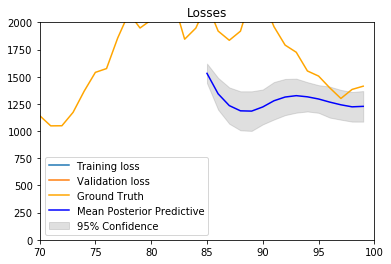

41
[29.72606  47.58458  51.51667  46.794895 44.3033   36.808666 50.471786
 51.736847 51.665817 52.361027 51.86415  51.765923 54.28787  56.623837
 56.730736]


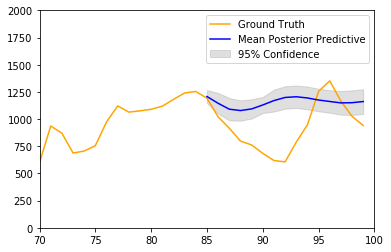

14
[34.752453 57.05359  71.20731  59.21824  49.179287 48.362095 48.935642
 49.592457 50.42035  42.258896 37.71387  44.929283 48.164833 53.247883
 55.02292 ]


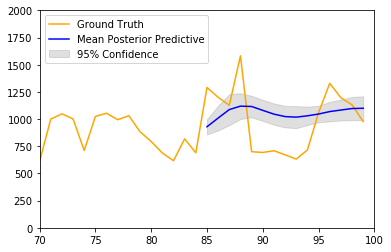

(100, 15)
(100, 15)
95 % interval 0.19399999999999995
rmse 442.51257
=================== air-O3 0.3 ===================
Epoch 1 Train loss: 0.71. Validation loss: 0.77. Avg future: 24.44. Elapsed time: 4.97s.
Epoch 2 Train loss: 0.42. Validation loss: 0.41. Avg future: 24.70. Elapsed time: 4.93s.
Epoch 3 Train loss: 0.29. Validation loss: 0.34. Avg future: 24.85. Elapsed time: 4.94s.
Epoch 4 Train loss: 0.26. Validation loss: 0.31. Avg future: 26.27. Elapsed time: 4.95s.
Epoch 5 Train loss: 0.24. Validation loss: 0.30. Avg future: 25.63. Elapsed time: 4.94s.
Epoch 6 Train loss: 0.24. Validation loss: 0.31. Avg future: 28.35. Elapsed time: 4.95s.
Epoch 7 Train loss: 0.24. Validation loss: 0.31. Avg future: 26.32. Elapsed time: 4.93s.
Epoch 8 Train loss: 0.24. Validation loss: 0.31. Avg future: 24.80. Elapsed time: 4.94s.
Epoch 9 Train loss: 0.24. Validation loss: 0.30. Avg future: 26.58. Elapsed time: 4.94s.
Epoch 10 Train loss: 0.24. Validation loss: 0.31. Avg future: 24.81. Elapsed ti

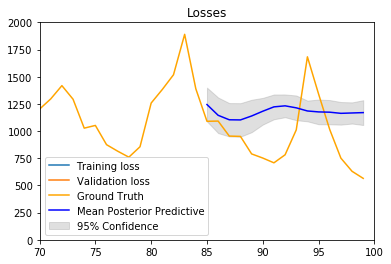

26
[53.827473 81.40087  83.94405  69.714005 53.53304  46.678936 44.253284
 37.863842 41.20346  42.5978   50.76546  49.0191   59.23689  54.895367
 48.723366]


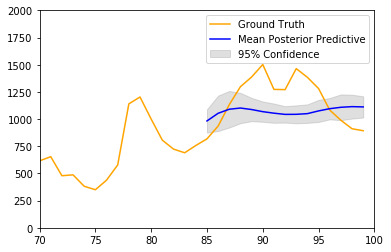

48
[48.014977 64.26032  66.12587  67.36003  54.55151  52.802654 59.820076
 63.943287 62.831345 68.71175  60.292084 51.93712  52.782326 51.39926
 48.011223]


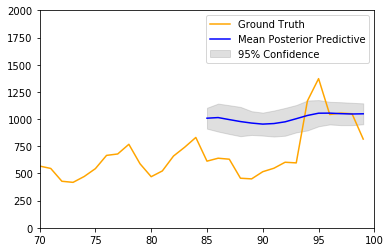

(100, 15)
(100, 15)
95 % interval 0.19466666666666665
rmse 458.85098
=================== air-O3 0.4 ===================
Epoch 1 Train loss: 0.73. Validation loss: 0.86. Avg future: 26.80. Elapsed time: 4.96s.
Epoch 2 Train loss: 0.46. Validation loss: 0.47. Avg future: 25.62. Elapsed time: 4.93s.
Epoch 3 Train loss: 0.32. Validation loss: 0.36. Avg future: 24.83. Elapsed time: 4.92s.
Epoch 4 Train loss: 0.27. Validation loss: 0.33. Avg future: 26.32. Elapsed time: 4.93s.
Epoch 5 Train loss: 0.26. Validation loss: 0.33. Avg future: 25.03. Elapsed time: 4.93s.
Epoch 6 Train loss: 0.26. Validation loss: 0.33. Avg future: 25.82. Elapsed time: 4.94s.
Epoch 7 Train loss: 0.25. Validation loss: 0.33. Avg future: 27.31. Elapsed time: 4.95s.
Epoch 8 Train loss: 0.26. Validation loss: 0.33. Avg future: 24.98. Elapsed time: 4.92s.
Epoch 9 Train loss: 0.25. Validation loss: 0.33. Avg future: 27.10. Elapsed time: 4.95s.
Epoch 10 Train loss: 0.25. Validation loss: 0.33. Avg future: 27.73. Elapsed ti

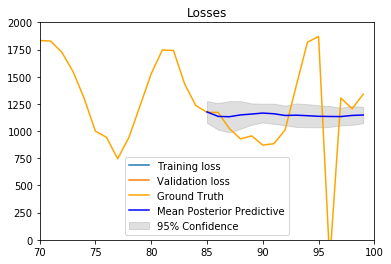

19
[22.983198 36.701942 37.832405 35.231125 29.763395 34.78414  35.71296
 41.746258 41.505013 40.38925  41.092464 49.187912 49.269756 48.974285
 42.738335]


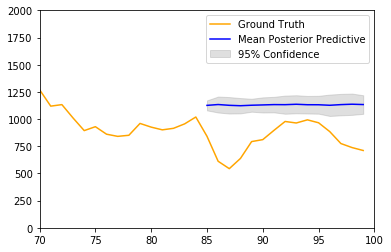

14
[ 69.526215 112.70352  108.950966  98.20177   81.8533    62.631287
  42.357574  39.18443   39.406338  37.0748    36.34844   37.4766
  40.62173   46.62114   48.871105]


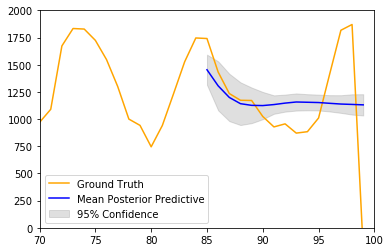

(100, 15)
(100, 15)
95 % interval 0.16733333333333333
rmse 458.0735
=================== air-O3 0.5 ===================
Epoch 1 Train loss: 0.74. Validation loss: 0.81. Avg future: 27.45. Elapsed time: 4.96s.
Epoch 2 Train loss: 0.44. Validation loss: 0.50. Avg future: 25.48. Elapsed time: 4.92s.
Epoch 3 Train loss: 0.33. Validation loss: 0.42. Avg future: 26.04. Elapsed time: 4.93s.
Epoch 4 Train loss: 0.29. Validation loss: 0.39. Avg future: 26.16. Elapsed time: 4.94s.
Epoch 5 Train loss: 0.28. Validation loss: 0.38. Avg future: 25.41. Elapsed time: 4.94s.
Epoch 6 Train loss: 0.28. Validation loss: 0.38. Avg future: 24.91. Elapsed time: 4.93s.
Epoch 7 Train loss: 0.27. Validation loss: 0.38. Avg future: 25.57. Elapsed time: 4.95s.
Epoch 8 Train loss: 0.27. Validation loss: 0.38. Avg future: 24.65. Elapsed time: 4.97s.
Epoch 9 Train loss: 0.27. Validation loss: 0.38. Avg future: 24.74. Elapsed time: 4.96s.
Epoch 10 Train loss: 0.27. Validation loss: 0.38. Avg future: 24.47. Elapsed tim

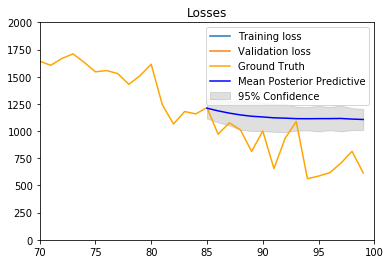

56
[58.57847  65.743126 65.99687  68.29889  68.28657  62.288586 59.235672
 57.94061  53.01271  47.640892 55.736633 56.918446 60.111927 57.91738
 60.117367]


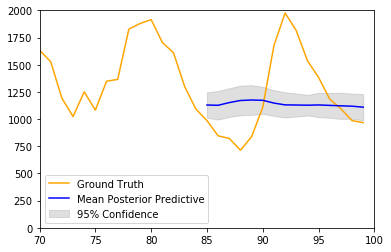

64
[ 69.50897   99.57527  104.46679  112.30102  100.50507   89.62539
  67.19847   56.632988  43.77225   41.51663   41.97858   36.705254
  37.43704   36.571953  43.42365 ]


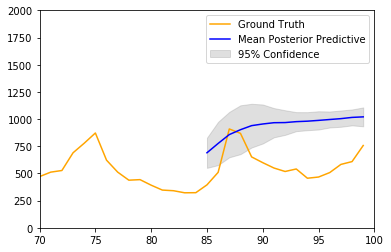

(100, 15)
(100, 15)
95 % interval 0.19333333333333336
rmse 478.07367


In [35]:
train_dataset('air-O3 0.2', air, 11, 100, dropout_frac=0.2)
train_dataset('air-O3 0.3', air, 11, 100, dropout_frac=0.3)
train_dataset('air-O3 0.4', air, 11, 100, dropout_frac=0.4)
train_dataset('air-O3 0.5', air, 11, 100, dropout_frac=0.5)



=================== finance-SP 0.2 ===================
Epoch 1 Train loss: 1.04. Validation loss: 1.16. Avg future: 9.88. Elapsed time: 0.24s.
Epoch 2 Train loss: 1.03. Validation loss: 1.18. Avg future: 8.88. Elapsed time: 0.24s.
Epoch 3 Train loss: 1.03. Validation loss: 1.18. Avg future: 8.88. Elapsed time: 0.24s.
Epoch 4 Train loss: 1.02. Validation loss: 1.18. Avg future: 10.21. Elapsed time: 0.24s.
Epoch 5 Train loss: 1.03. Validation loss: 1.18. Avg future: 6.25. Elapsed time: 0.23s.
Epoch 6 Train loss: 1.03. Validation loss: 1.18. Avg future: 7.33. Elapsed time: 0.24s.
Epoch 7 Train loss: 1.02. Validation loss: 1.18. Avg future: 8.25. Elapsed time: 0.24s.
Epoch 8 Train loss: 1.02. Validation loss: 1.18. Avg future: 8.71. Elapsed time: 0.24s.
Epoch 9 Train loss: 1.03. Validation loss: 1.18. Avg future: 8.33. Elapsed time: 0.24s.
Epoch 10 Train loss: 1.02. Validation loss: 1.18. Avg future: 9.25. Elapsed time: 0.24s.
Evaluation
shape torch.Size([32, 15, 50])
1
[2.3150804 2.363120

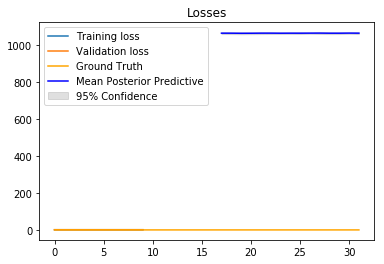

19
[2.6812415 2.7861874 2.501593  2.3627367 2.0314481 2.0031106 2.265704
 2.0647252 2.2328875 2.380388  2.2796926 2.2715645 2.2503152 2.4009342
 2.238301 ]


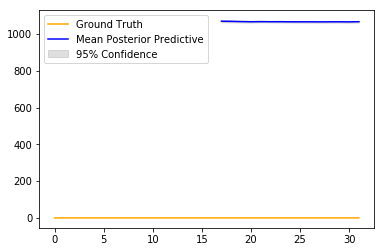

17
[2.4198966 2.042271  2.2311802 2.126459  2.151891  2.2708774 2.7294252
 1.9676437 2.5403576 2.18526   2.1498272 2.4349773 2.4696774 2.0883777
 2.0372453]


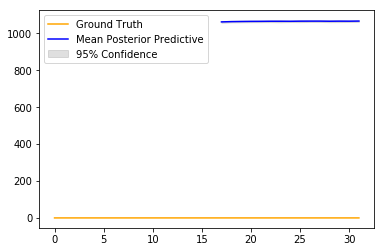

(32, 15)
(32, 15)
95 % interval 0.0
rmse 1066.3632
=================== finance-SP 0.3 ===================
Epoch 1 Train loss: 1.03. Validation loss: 1.31. Avg future: 11.41. Elapsed time: 0.32s.
Epoch 2 Train loss: 1.02. Validation loss: 1.32. Avg future: 15.00. Elapsed time: 0.32s.
Epoch 3 Train loss: 1.02. Validation loss: 1.32. Avg future: 13.64. Elapsed time: 0.32s.
Epoch 4 Train loss: 1.02. Validation loss: 1.32. Avg future: 14.68. Elapsed time: 0.32s.
Epoch 5 Train loss: 1.02. Validation loss: 1.32. Avg future: 13.64. Elapsed time: 0.32s.
Epoch 6 Train loss: 1.02. Validation loss: 1.32. Avg future: 10.55. Elapsed time: 0.32s.
Epoch 7 Train loss: 1.02. Validation loss: 1.32. Avg future: 15.18. Elapsed time: 0.32s.
Epoch 8 Train loss: 1.02. Validation loss: 1.32. Avg future: 13.00. Elapsed time: 0.32s.
Epoch 9 Train loss: 1.02. Validation loss: 1.32. Avg future: 15.14. Elapsed time: 0.32s.
Epoch 10 Train loss: 1.02. Validation loss: 1.32. Avg future: 12.32. Elapsed time: 0.32s.
Eva

ZeroDivisionError: float division by zero

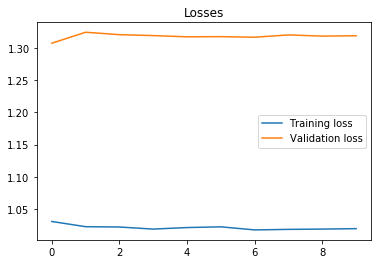

In [45]:
train_dataset('finance-SP 0.2', finance, 3, 32, dropout_frac=0.2)
train_dataset('finance-SP 0.3', finance, 3, 50, dropout_frac=0.3)
train_dataset('finance-SP 0.4', finance, 3, 50, dropout_frac=0.4)
train_dataset('finance-SP 0.5', finance, 3, 50, dropout_frac=0.5)



In [ ]:
train_dataset('finance-EU 0.2', finance, 8, 100, dropout_frac=0.2)


1772
tensor([[1160.5367, 1159.7139, 1137.2438,  ..., 1120.2156, 1116.5665,
         1111.9076],
        [1059.8949, 1080.9692, 1105.0917,  ..., 1107.8646, 1107.6251,
         1105.9015],
        [ 877.3689,  961.8879, 1040.7273,  ..., 1095.4100, 1113.9980,
         1111.1278],
        ...,
        [1061.3390, 1077.4598, 1089.7007,  ..., 1104.2100, 1108.0956,
         1104.7697],
        [1231.9745, 1168.9470, 1121.8966,  ..., 1102.6510, 1106.9744,
         1108.7733],
        [ 994.5922, 1022.2541, 1076.5813,  ..., 1079.6898, 1088.3248,
         1091.7345]])
tensor([[-0.8058, -0.5472, -0.5097,  ...,  0.7869,  1.3144,  1.0150],
        [-0.5472, -0.5097,  0.6712,  ...,  1.3144,  1.0150,  0.6440],
        [-0.5097,  0.6712,  0.8142,  ...,  1.0150,  0.6440,  0.5487],
        ...,
        [-0.7582, -0.5165,  0.3922,  ..., -0.0162, -0.1388, -0.2817],
        [-0.5165,  0.3922,  0.1199,  ..., -0.1388, -0.2817, -0.6356],
        [ 0.3922,  0.1199, -0.2272,  ..., -0.2817, -0.6356, -0.8637]])
t

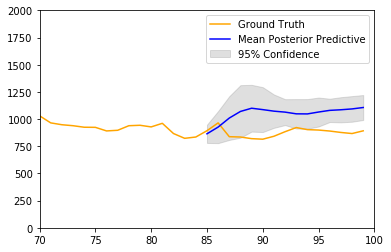

99
[35.289387 53.451324 61.581207 66.69545  56.006313 46.054226 52.206894
 57.27341  56.217804 61.376343 56.70477  61.923847 58.134377 59.834137
 49.515846]


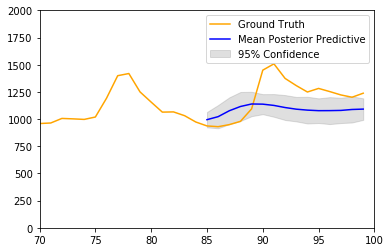

In [14]:
# print(x_test[:32,:].shape)
# print(predicted_mean.shape)
print(x_test.shape[0])

gt = x_test[:test_size,:].cpu().detach().numpy()

gt = scaler.inverse_transform(gt)

print(predicted_mean)
print(y_test[:test_size,-FUTURE:])

test_mse_loss = nn.functional.mse_loss(predicted_mean,y_test[:test_size,-FUTURE:],reduction='mean').cpu().detach().numpy()
print('test mse loss ',test_mse_loss)
print('gt',gt.shape)
seq_length = 0
i = 12
# print(predicted_sd)
# gt = np.random.rand(32,seq_length+future)
mean = predicted_mean.cpu().detach().numpy()
std = predicted_sd.cpu().detach().numpy()
# print(mean-std)

# mean = scaler.inverse_transform(mean)
# std = scaler.inverse_transform(std)
# print(std)
future = mean.shape[1]
seq_length = x_test.shape[1]
x_gt = np.arange(seq_length)
x_pred = np.arange(seq_length-future,seq_length)
# print(std[i,:])
# std[:,:seq_length-future] = 0
for count in np.arange(2):
    i = np.asscalar(np.random.randint(low=0, high=test_size, size=1))
    print(i)
    print(std[i,:])
    plt.figure
    plt.plot(x_gt, gt[i,:], color='orange', label='Ground Truth')
    plt.plot(x_pred, mean[i,:], color='b', label='Mean Posterior Predictive')
    plt.fill_between(x_pred, mean[i,:]-2*std[i,:], mean[i,:]+2*std[i,:], color='grey', alpha = 0.25, label='95% Confidence')
    plt.legend()
    plt.xlim((70,100))
    plt.ylim((0,2000))
    plt.show()

In [7]:
a = torch.Tensor([ 9.3930e-01,  5.7698e-01,  3.8233e-01,  3.2158e-01,  1.5642e-02,
         6.0218e-02,  9.4245e-02,  6.8051e-02, -1.5803e-01,  1.1131e-03,
         3.3073e-01,  3.5391e-01,  5.6218e-01,  6.3405e-01,  1.1382e+00,
         1.2158e+00,  8.5759e-01,  8.3186e-01,  9.6237e-01,  1.0465e+00,
         6.1472e-01,  7.9351e-01,  1.0348e+00,  9.2465e-01,  9.5023e-01,
         9.4609e-01,  1.3731e+00,  1.3814e+00,  1.2956e+00,  1.0654e+00,
         1.1960e+00,  7.9728e-01])

In [8]:
a.view(-1,1).shape

torch.Size([32, 1])

In [9]:
y_mean=torch.Tensor([4,4])
y_std=torch.Tensor([1,1])
torch.normal(y_mean, y_std)

tensor([5.6052, 2.5236])

In [10]:
# TODO: adapt this code to previous code which shows confidence intervals
# this part was taken from repo shared by Arka

# here we predict and get uncertainty
# we should design the experiment

samples = 100
x_tmp = torch.linspace(-100,100,1000).reshape(-1,1).to(device)
y_samp = np.zeros((samples,1000))
for s in range(samples):
    y_tmp = net(x_tmp).cpu().detach().numpy()
    y_samp[s] = y_tmp.reshape(-1)
plt.plot(x_tmp.cpu().numpy(), np.mean(y_samp, axis = 0), label='Mean Posterior Predictive')
plt.fill_between(x_tmp.cpu().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis = 0), np.percentile(y_samp, 97.5, axis = 0), alpha = 0.25, label='95% Confidence')
plt.legend()
plt.scatter(x, toy_function(x))
plt.title('Posterior Predictive')
plt.show()

NameError: name 'net' is not defined